In [ ]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.feature_extraction.text import HashingVectorizer
import numpy as np
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pickle

In [ ]:
chunks = []
for chunk in pd.read_csv('combined_dataset.csv', chunksize=10000):
    chunks.append(chunk)
df = pd.concat(chunks, axis=0)

In [ ]:
# Try reading with error_bad_lines=False to skip problematic rows
#df = pd.read_csv('combined_dataset.csv', error_bad_lines=False)

In [ ]:
models = {
    "SVM": SVC(kernel='linear', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

In [ ]:
df.drop('Unnamed: 0',axis=1, inplace=True)

In [ ]:
df.describe()

,label
count,151254.000000
mean,0.530075
std,0.499096
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151254 entries, 0 to 151253
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   payload  151253 non-null  object
 1   label    151254 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [ ]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150568 entries, 0 to 151253
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   payload  150568 non-null  object
 1   label    150568 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


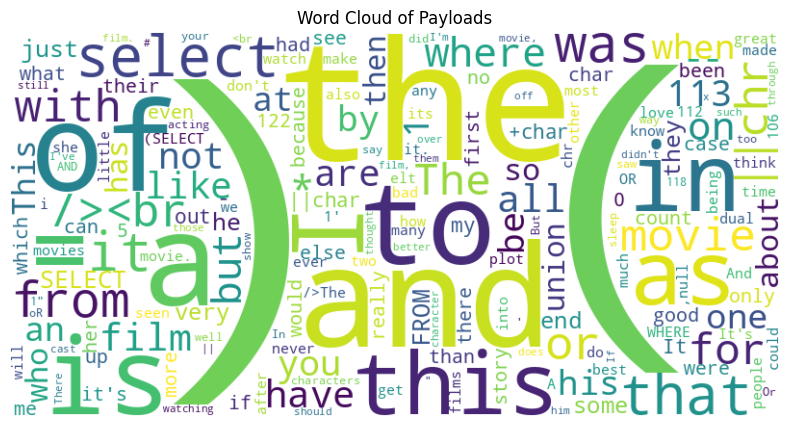

In [ ]:
all_text = " ".join(df["payload"])
word_counts = Counter(all_text.split())

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Payloads")
plt.show()

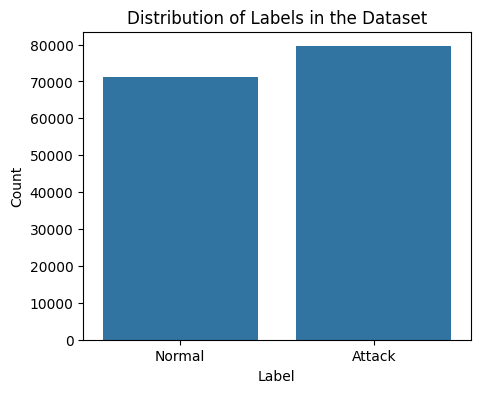

In [ ]:
label_counts = df["label"].value_counts()

plt.figure(figsize=(5, 4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels in the Dataset")
plt.xticks([0, 1], ["Normal", "Attack"])
plt.show()

In [ ]:
X = df['payload']
y = df['label']

In [ ]:
def preprocess_text(text):

    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [ ]:
X_processed = [preprocess_text(payload) for payload in X]
vectorizer = HashingVectorizer(
    analyzer='char',
    ngram_range=(3, 5),
    n_features=2**20,
    dtype=np.float32
)
X_features = vectorizer.transform(X_processed)
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.svm import LinearSVC  # Faster than SVC for linear kernels

# Use LinearSVC instead of SVC for linear kernels (much faster)
svm_model = LinearSVC(C=1.0, random_state=42, dual=False)  # dual=False when n_samples > n_features
svm_model.fit(X_train, y_train)

LinearSVC(dual=False, random_state=42)

In [ ]:
'''from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Scale data first (KNN is distance-based)
knn_model = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(
        n_neighbors=5,
        algorithm='ball_tree',  # or 'kd_tree' for faster neighbor searches
        n_jobs=-1  # Enable parallel processing
    )
)
knn_model.fit(X_train, y_train)

SyntaxError: incomplete input (<ipython-input-26-445e6dc80a14>, line 1)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# For sparse data (like TF-IDF output), use with_mean=False
knn_model = make_pipeline(
    StandardScaler(with_mean=False),  # Critical for sparse data
    KNeighborsClassifier(
        n_neighbors=5,
        algorithm='brute',  # Best algorithm for sparse data
        metric='cosine',    # Better than Euclidean for text data
        n_jobs=-1           # Enable parallel processing
    )
)
knn_model.fit(X_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(
    n_estimators=50,  # Reduced from 100 (often good enough)
    max_depth=10,     # Limit tree depth
    min_samples_split=10,  # Reduce overfitting
    n_jobs=-1,
    random_state=42
)
random_forest_model.fit(X_train, y_train)

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(
    solver='saga',  # Faster for large datasets
    penalty='l1',   # L1 regularization (sparse solutions)
    max_iter=500,   # Reduced from 1000
    random_state=42,
    n_jobs=-1       # Enable parallel processing
)
logreg_model.fit(X_train, y_train)

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(
    solver='liblinear',  # Faster for small-to-medium datasets
    penalty='l1',       # Corrected from '11' to 'l1'
    C=1.0,              # Inverse regularization strength
    max_iter=10,       # Often converges much faster
    random_state=42,
    warm_start=False,   # Disable for single training
    verbose=0,          # Disable logging
    tol=1e-4,           # Slightly looser tolerance for faster convergence
    n_jobs=-1           # Parallel processing
)

# For large datasets (>100K samples), use:
# solver='sag' or 'saga' with penalty='l2'
# And add: batch_size=1000

logreg_model.fit(X_train, y_train)

In [ ]:
#random_forest_model = RandomForestClassifier(
 #   n_estimators=100,
  #  n_jobs=-1,
   # random_state=42
#)
#random_forest_model.fit(X_train, y_train)

In [ ]:
"""from sklearn.svm import LinearSVC  # Missing import
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pickle
import time

# Rest of your code remains the same
models = {
    "SVM": LinearSVC(dual=False, max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42),
    "KNN": KNeighborsClassifier(n_jobs=-1, algorithm='brute'),
    "LogReg": LogisticRegression(solver='saga', max_iter=500, n_jobs=-1)
}

# ... rest of your training/evaluation code ...
# 2. Train models with timing
for name, model in models.items():
    start_time = time.time()

    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Store metrics
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "Time": time.time() - start_time
    }

    # Save model (once per model)
    with open(f"models/{name.lower()}_model.pkl", "wb") as f:
        pickle.dump(model, f)

# 3. Save vectorizer ONCE outside loop
with open("models/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# 4. Print results after all processing
print("\nModel Performance Summary:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"  Accuracy: {metrics['Accuracy']:.4f}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  Recall: {metrics['Recall']:.4f}")
    print(f"  Training Time: {metrics['Time']:.2f}s")

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
results = {}

from sklearn.feature_extraction.text import TfidfVectorizer  # Correct capitalization

# Sample data validation and cleaning
texts = [
    "normal request 1",
    "malicious request 1",
    # Replace any ellipsis (...) or non-string items
    "another normal request",
    "another malicious request"
]

# Ensure all items are strings and handle missing values
texts = [str(text) if text is not ... else "" for text in texts]  # Handle ellipsis
texts = [text.lower().strip() for text in texts]  # Pre-lowercase and clean

# Vectorize text
vectorizer = TfidfVectorizer()  # Correct spelling with capital 'T'
X = vectorizer.fit_transform(texts)
"""
# Example for text data
texts = ["normal request 1", "malicious request 1", ...]
labels = [0, 1, ...]  # 0=normal, 1=malicious

# Vectorize text
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)
"""
# Then split X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Store metrics
results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred)
    }

    # Save the model
pickle.dump(model, open(f"models/{name.lower().replace(' ', '_')}_model.pkl", "wb"))

# Save vectorizer
pickle.dump(vectorizer, open("models/tfidf_vectorizer.pkl", "wb"))

# Print results
print("Model Performance:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"Accuracy: {metrics['Accuracy']:.2f}")
    print(f"Precision: {metrics['Precision']:.2f}")
    print(f"Recall: {metrics['Recall']:.2f}")


In [ ]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

In [ ]:
models = {
    "SVM": SVC(kernel='linear', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_model = XGBClassifier(tree_method="hist", n_jobs=-1)
xgb_model.fit(X_train, y_train)